In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df= pd.read_csv(r"C:\Users\austi\Downloads\netflix_titles.csv\netflix_titles.csv")
df.shape

(6234, 12)

In [2]:
df.sample(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
4199,60020236,Movie,Heartbreakers,David Mirkin,"Sigourney Weaver, Jennifer Love Hewitt, Ray Li...",United States,"December 31, 2019",2001,PG-13,124 min,"Comedies, Romantic Movies","In this stylish comedy, a mother-daughter con ..."
246,80168230,Movie,Strong Island,Yance Ford,NaN,"United States, Denmark","September 15, 2017",2017,TV-MA,108 min,Documentaries,"The forces of family, grief and racial injusti..."
5764,80144355,TV Show,Mars,Everardo Gout,"Jihae, Alberto Ammann, Clémentine Poidatz, Ana...",United States,"November 1, 2019",2018,TV-PG,2 Seasons,"Docuseries, Science & Nature TV, TV Dramas",Fact meets fiction in this docudrama chronicli...


Checking for nulls.

In [3]:
for c in df.columns:
    na_count = df[c].isna().sum()
    if na_count > 0:
        print(f'{c} has {na_count} nulls')

director has 1969 nulls
cast has 570 nulls
country has 476 nulls
date_added has 11 nulls
rating has 10 nulls


There are quite a lot of null values in 'director', 'cast', and 'country.'

In [4]:
df=df.fillna('NA')
df['year_added'] = df['date_added'].apply(lambda x: x.split(',')[-1])
df['year_added'] = df['year_added'].replace('NA', 2020).astype('int') #assuming titles with null date added is unreleased/will be released in 2020

We can first look at the number of titles added to Netflix over time.

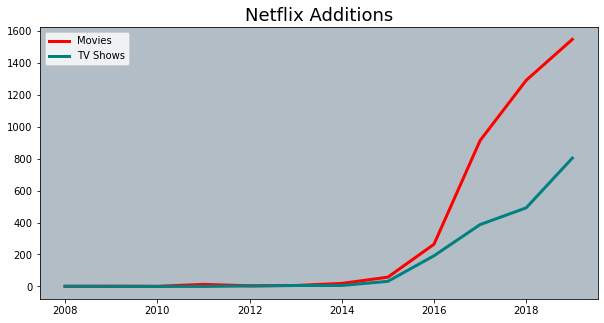

In [5]:
df_2 = df[df.year_added != 2020] #2020 additions are incomplete and are excluded
type_pivot = df_2.pivot_table(index='year_added', columns='type',aggfunc={'type':len}, fill_value=0)['type']

fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(type_pivot.index, type_pivot.Movie, linewidth=3, color='red', label='Movies')
ax.plot(type_pivot.index, type_pivot['TV Show'], linewidth=3, color='teal', label='TV Shows')
ax.set_title("Netflix Additions", fontsize=18) 
ax.set_facecolor('#b3bdc6')
ax.legend() 

plt.show()

Because each title can be released in multiple countries, the 'Country' column is formatted like "Country 1, Country 2, etc." We will need to split up each cell by ',' to count every country individually.

In [6]:
#ensuring consistent splitting
df['country']= df['country'].str.replace(' ,',',').str.replace(', ',',')

countries = df['country']
c_count = pd.Series(df.country.str.split(',').sum()).value_counts().sort_values(ascending=False)
c_count.drop('NA', axis=0, inplace=True)
c_count

United States     2610
India              838
United Kingdom     602
Canada             318
France             271
                  ... 
Cyprus               1
Afghanistan          1
Vatican City         1
Slovakia             1
Latvia               1
Length: 111, dtype: int64

Now we can plot the countries with the most and fewest Netflix additions.

([<matplotlib.patches.Wedge at 0x1799164e9a0>,
 [Text(0.8899186877588753, 0.6465637858537406, 'Cyprus'),
  Text(-0.3399187231970732, 1.046162158377023, 'Afghanistan'),
  Text(-1.0999999999999988, -5.149471622296949e-08, 'Vatican City'),
  Text(-0.33991862524830174, -1.0461621902025062, 'Slovakia'),
  Text(0.8899187482945414, -0.6465637025335375, 'Latvia')])

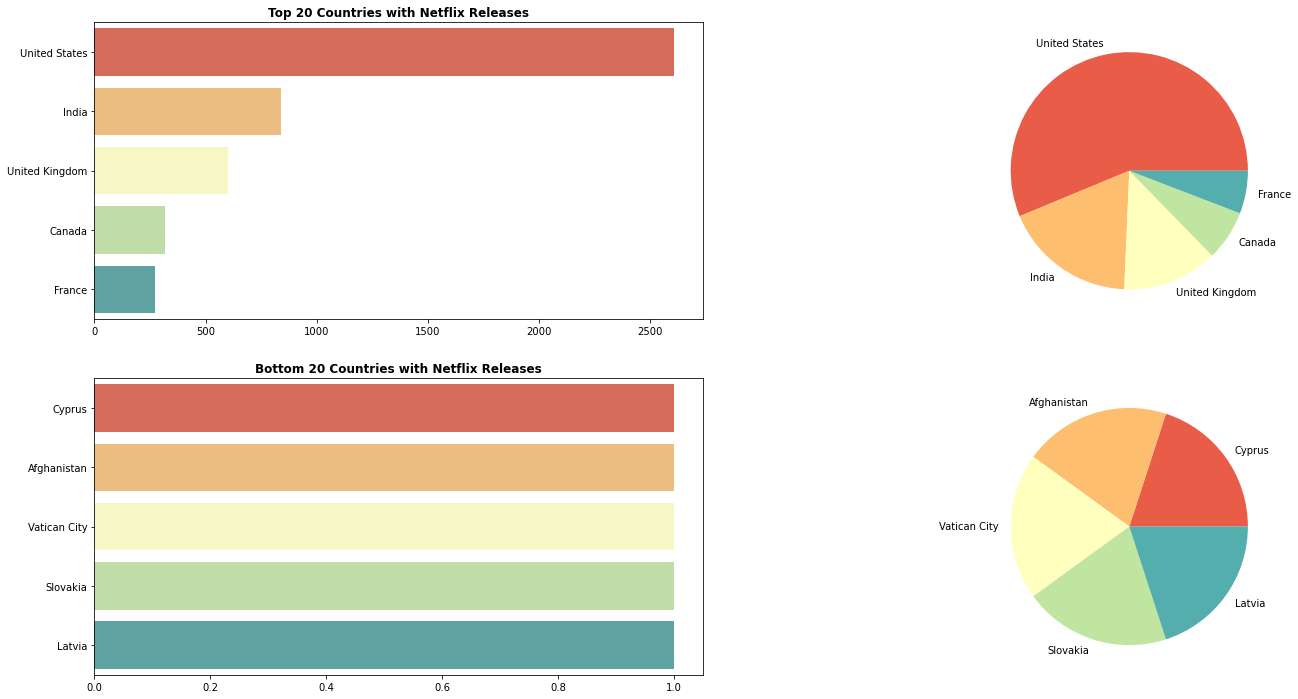

In [7]:
c_5 = c_count[:5]
c_bottom_5= c_count[-5:]

from matplotlib import gridspec

fig = plt.figure(figsize=(24,12))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios = [4,4], width_ratios=[10,10])

ax=plt.subplot(gs[0])
sns.barplot(y=c_5.index, x=c_5, ax=ax, palette= 'Spectral')
ax.set_title('Top 20 Countries with Netflix Releases', fontsize=12, fontweight='bold')

ax2 = plt.subplot(gs[1])
ax2.pie(c_5, labels=c_5.index, colors=sns.color_palette("Spectral", n_colors=5))

ax=plt.subplot(gs[2])
sns.barplot(y=c_bottom_5.index, x=c_bottom_5, ax=ax, palette= 'Spectral')
ax.set_title('Bottom 20 Countries with Netflix Releases', fontsize=12, fontweight='bold')

ax2 = plt.subplot(gs[3])
ax2.pie(c_bottom_5, labels=c_bottom_5.index, colors=sns.color_palette("Spectral", n_colors=5))

Creating dummy variables for each country to analyze them individually

In [8]:
df2 = pd.concat([df, df['country'].str.get_dummies(sep=',')], axis=1)

In [9]:
df.rating.unique()

array(['TV-PG', 'TV-MA', 'TV-Y7-FV', 'TV-Y7', 'TV-14', 'R', 'TV-Y', 'NR',
       'PG-13', 'TV-G', 'PG', 'G', 'NA', 'UR', 'NC-17'], dtype=object)

There are quite a few labels for rating. We can group some of them together based on similar age ranges. This will help us better visualize the amount of titles across age groups.

In [10]:
rating_groups = {
    'G and 7': ['G', 'TV-G', 'TV-Y', 'TV-Y7', 'TV-Y7-FV'],
    'PG': ['PG', 'TV-PG'],
    '13-14': ['PG-13','TV-14'],
    'Mature': ['NC-17', 'R', 'TV-MA'],
    'No Rating': ['NA', 'NR', 'UR']
}

for r, t in rating_groups.items():
    df2.loc[df2['rating'].isin(t), 'rating'] = r

Next we can plot the number of additions by age rating in each year.

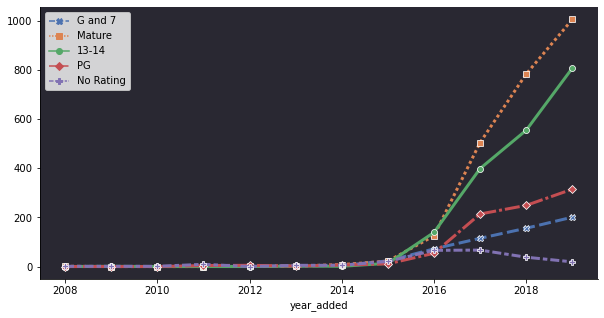

In [11]:
df_rating = pd.crosstab(df2.year_added, df2.rating).drop(2020)

rating_hue_order = ['G and 7', 'Mature', '13-14', 'PG', 'No Rating']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_rating, palette='deep', markers=True, linewidth = 3, hue_order=rating_hue_order)
ax.set_facecolor('#292832')
sns.despine()

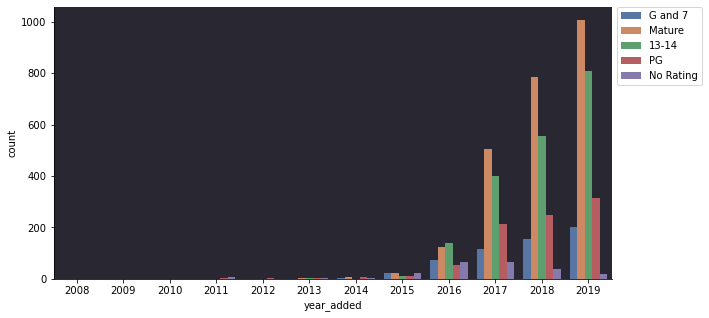

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data=df2[df2.year_added != 2020], x='year_added', hue='rating', palette='deep', hue_order=rating_hue_order)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
ax.set_facecolor('#292832')
sns.despine()

Using the Country dummy variables created earlier, we can look at the additions by age group for specific countries.

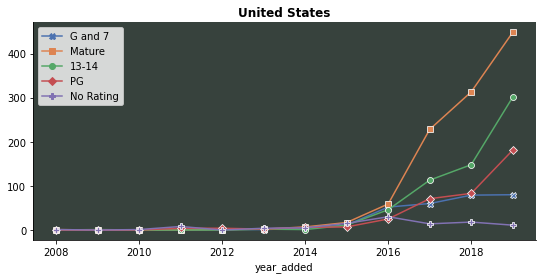

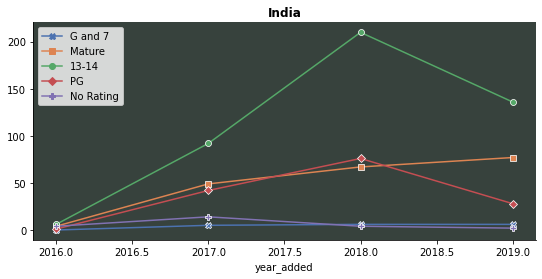

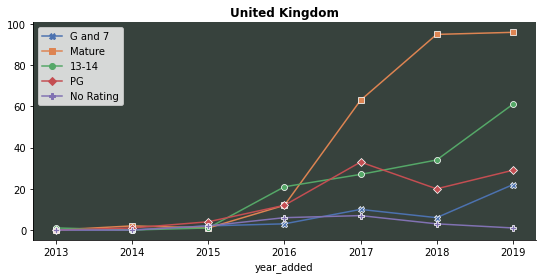

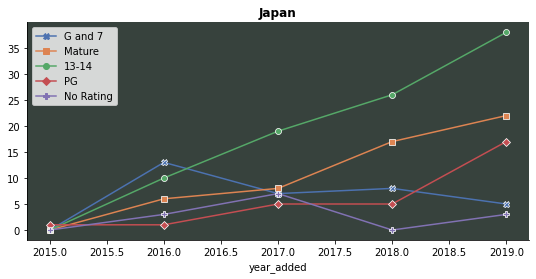

In [13]:
countries_ratings = ['United States', 'India', 'United Kingdom', 'Japan']

for c in countries_ratings:
    df_c=df2[df2[c] == 1]
    df_c_rating = pd.crosstab(df_c.year_added, df_c.rating).drop(2020)
    
    fig, ax = plt.subplots(figsize=(9,4))
    sns.lineplot(data=df_c_rating, dashes=False, palette='deep', hue_order=rating_hue_order, markers=True)
    plt.title(c, fontweight='bold')
    ax.set_facecolor('#37423D')
    sns.despine()

Among the countries plotted, there are significantly more 'Mature' titles added in the US and the UK. This is not the case in India and Japan, where the titles are primarily rated in the '13-14' category. This may be due to different preferences in entertainment between western and eastern cultures. These particular countires were selected to show the differences in cultures.

We can also analyze the relationship between age ratings and genres.

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
df_gen_movie = df2[df2.type == 'Movie']
df_gen_tv = df2[df2.type == 'TV Show']

def mlb_heat_plot(table):
    table['genres']= table['listed_in'].str.replace(' ,',',').str.replace(', ',',').str.split(',')
    mlb = MultiLabelBinarizer()
    gen = table['genres']
    df_gen = pd.DataFrame(mlb.fit_transform(gen), columns=mlb.classes_, index=gen.index)
    df_gen = df_gen.join(table['rating'])
    df_gen=df_gen.set_index('rating')
    df_group = df_gen.groupby(level='rating').sum()
    fig, ax = plt.subplots()
    fig.set_size_inches(20,4)
    sns.heatmap(df_group, cmap='CMRmap', square=True)

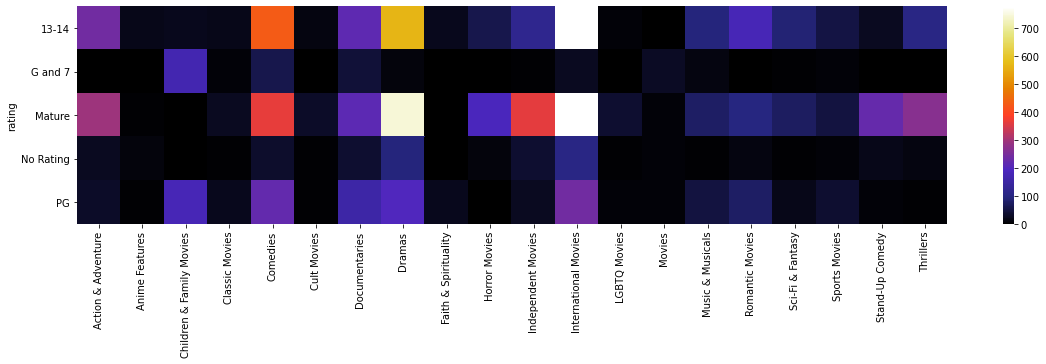

In [15]:
mlb_heat_plot(df_gen_movie)

As we saw earlier, most movies fall in the 13-14 and Mature ratings. Netflix seems to have the most Comedies, Dramas, and International Movies in its library. Comedies have a greater proportion of movies rated as 13-14, whereas there are more Mature rated Dramas, Action and Adventurem and Independent movies than 13-14 rated. International movies and Documentaries are evenly split between the two ratings.

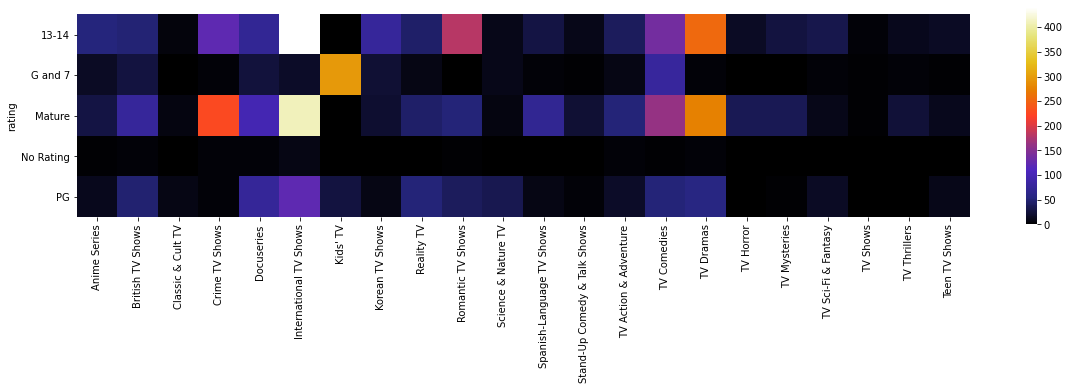

In [16]:
mlb_heat_plot(df_gen_tv)

The distribution among TV shows is similar to movies. Most genres seem to be pretty evenly split among the mature and 13-14 ratings, with a slight skew towards mature. Crime TV shows are largely mature rated. Romatic shows and Anime series are more commonly rated 13-14.

We can also take a look at the directors with the most content on Netflix

In [17]:
director_list = df['director']
d_count = pd.Series(df.director).value_counts().sort_values(ascending=False)
d_count.drop('NA', axis=0, inplace=True)
top10_d=d_count[:10]
top10_d

Raúl Campos, Jan Suter    18
Marcus Raboy              14
Jay Karas                 13
Jay Chapman               12
Martin Scorsese            9
Steven Spielberg           9
David Dhawan               8
Lance Bangs                8
Johnnie To                 8
S.S. Rajamouli             7
Name: director, dtype: int64

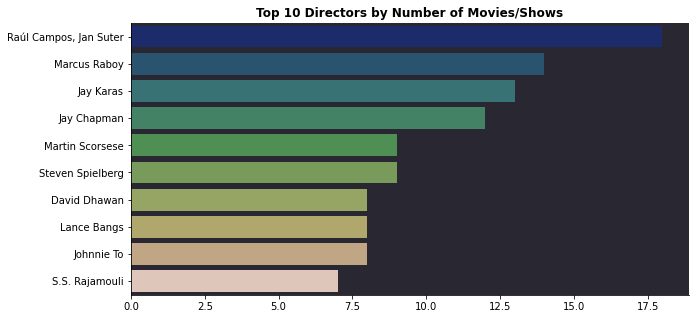

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(y=top10_d.index, x=top10_d.values, orient='h', palette='gist_earth')
ax.set_facecolor('#292832')
plt.title('Top 10 Directors by Number of Movies/Shows', fontweight='bold')
sns.despine()

Displaying all directors in a Word Cloud

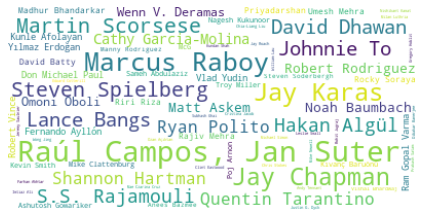

In [20]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white').generate_from_frequencies(d_count)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout() 